In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta,date

# 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('icefire_r', 2)
import warnings

%matplotlib inline
#Przetwarzanie

# Baza danych gównych do nauki modelu
train = pd.read_csv("train.csv") 
# Baza danych Titanica do sprawdzenia modelu
test = pd.read_csv("test.csv")

In [2]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [3]:
test.head()

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


In [4]:
print(pd.isnull(train).sum())

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64


In [5]:
print(pd.isnull(test).sum())

id         0
date       0
country    0
store      0
product    0
dtype: int64


In [6]:
cols= ['country', 'store', 'product' ]
for col in cols:
  df_grouped = train.groupby(col)[col].count()
  df_grouped = df_grouped / train[col].count() * 100
  print(f"Unique value counts and percentages for column {col}:")
  print(df_grouped)

Unique value counts and percentages for column country:
country
Argentina    20.0
Canada       20.0
Estonia      20.0
Japan        20.0
Spain        20.0
Name: country, dtype: float64
Unique value counts and percentages for column store:
store
Kagglazon       33.333333
Kaggle Learn    33.333333
Kaggle Store    33.333333
Name: store, dtype: float64
Unique value counts and percentages for column product:
product
Using LLMs to Improve Your Coding                 20.0
Using LLMs to Train More LLMs                     20.0
Using LLMs to Win Friends and Influence People    20.0
Using LLMs to Win More Kaggle Competitions        20.0
Using LLMs to Write Better                        20.0
Name: product, dtype: float64


In [7]:
cols= ['country', 'store', 'product' ]
for col in cols:
  df_grouped = test.groupby(col)[col].count()
  df_grouped = df_grouped / test[col].count() * 100
  print(f"Unique value counts and percentages for column {col}:")
  print(df_grouped)

Unique value counts and percentages for column country:
country
Argentina    20.0
Canada       20.0
Estonia      20.0
Japan        20.0
Spain        20.0
Name: country, dtype: float64
Unique value counts and percentages for column store:
store
Kagglazon       33.333333
Kaggle Learn    33.333333
Kaggle Store    33.333333
Name: store, dtype: float64
Unique value counts and percentages for column product:
product
Using LLMs to Improve Your Coding                 20.0
Using LLMs to Train More LLMs                     20.0
Using LLMs to Win Friends and Influence People    20.0
Using LLMs to Win More Kaggle Competitions        20.0
Using LLMs to Write Better                        20.0
Name: product, dtype: float64


In [8]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [9]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Enc_col = ['country', 'store', 'product' ]

# Fit the encoder and create the mapping for each column separately
categories = {}
for col in Enc_col:
    for df in [train, test]:
        df[col + '_Enc'] = enc.fit_transform(df[col].values.reshape(-1, 1))
    categories[col] = enc.categories_[0]  # Store categories for the current column

# Print the mapping
for col in Enc_col:
    print(f"Kolumna: {col}")
    for i, category in enumerate(categories[col]):
        print(f"  Wartość zakodowana: {i} -> Wartość początkowa: {category}")

Kolumna: country
  Wartość zakodowana: 0 -> Wartość początkowa: Argentina
  Wartość zakodowana: 1 -> Wartość początkowa: Canada
  Wartość zakodowana: 2 -> Wartość początkowa: Estonia
  Wartość zakodowana: 3 -> Wartość początkowa: Japan
  Wartość zakodowana: 4 -> Wartość początkowa: Spain
Kolumna: store
  Wartość zakodowana: 0 -> Wartość początkowa: Kagglazon
  Wartość zakodowana: 1 -> Wartość początkowa: Kaggle Learn
  Wartość zakodowana: 2 -> Wartość początkowa: Kaggle Store
Kolumna: product
  Wartość zakodowana: 0 -> Wartość początkowa: Using LLMs to Improve Your Coding
  Wartość zakodowana: 1 -> Wartość początkowa: Using LLMs to Train More LLMs
  Wartość zakodowana: 2 -> Wartość początkowa: Using LLMs to Win Friends and Influence People
  Wartość zakodowana: 3 -> Wartość początkowa: Using LLMs to Win More Kaggle Competitions
  Wartość zakodowana: 4 -> Wartość początkowa: Using LLMs to Write Better


In [10]:
categorical_features = ['id','country', 'store', 'product' ]
for df in [train, test]:
     df.drop(columns=categorical_features, inplace=True)

In [11]:
train.tail()

,date,num_sold,country_Enc,store_Enc,product_Enc
136945,2021-12-31,700,4.0,0.0,0.0
136946,2021-12-31,752,4.0,0.0,1.0
136947,2021-12-31,111,4.0,0.0,2.0
136948,2021-12-31,641,4.0,0.0,3.0
136949,2021-12-31,539,4.0,0.0,4.0


In [12]:
test.head()

,date,country_Enc,store_Enc,product_Enc
0,2022-01-01,0.0,1.0,0.0
1,2022-01-01,0.0,1.0,1.0
2,2022-01-01,0.0,1.0,2.0
3,2022-01-01,0.0,1.0,3.0
4,2022-01-01,0.0,1.0,4.0


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         136950 non-null  datetime64[ns]
 1   num_sold     136950 non-null  int64         
 2   country_Enc  136950 non-null  float64       
 3   store_Enc    136950 non-null  float64       
 4   product_Enc  136950 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 5.2 MB


In [14]:
train[['country_Enc', 'store_Enc', 'product_Enc']] = train[['country_Enc', 'store_Enc', 'product_Enc']].astype(np.int8)
test[['country_Enc', 'store_Enc', 'product_Enc']] = test[['country_Enc', 'store_Enc', 'product_Enc']].astype(np.int8)
train['num_sold'] = train['num_sold'].astype(np.int16)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         136950 non-null  datetime64[ns]
 1   num_sold     136950 non-null  int16         
 2   country_Enc  136950 non-null  int8          
 3   store_Enc    136950 non-null  int8          
 4   product_Enc  136950 non-null  int8          
dtypes: datetime64[ns](1), int16(1), int8(3)
memory usage: 1.7 MB


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         27375 non-null  datetime64[ns]
 1   country_Enc  27375 non-null  int8          
 2   store_Enc    27375 non-null  int8          
 3   product_Enc  27375 non-null  int8          
dtypes: datetime64[ns](1), int8(3)
memory usage: 294.2 KB


In [17]:
print(train['date'].isna().any()) 
train = train.set_index('date')
test = test.set_index('date')

False


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam  # Import Adam optimizer

from tqdm import tqdm


In [19]:
features = ["country_Enc", "store_Enc", "product_Enc"]
target   = 'num_sold'

# Przygotuj dane dla modelu
X_train = train[features]
y_train = train[target]

X_test = test[features]

# Konwertuj dane na tensory PyTorch
X_tensor_train = torch.from_numpy(X_train.to_numpy()).half()
y_tensor_train = torch.from_numpy(y_train.to_numpy()).half().reshape(-1, 1)

# Konwertuj dane na tensory PyTorch
X_tensor_test = torch.from_numpy(X_test.to_numpy()).half()

class MyDataset(torch.utils.data.Dataset):
  def __init__(self, X_tensor, y_tensor):
    if y_tensor is not None:
      # Handle missing labels (e.g., assign a specific value)
      self.y_tensor = [label if label is not None else -1 for label in y_tensor]
    self.X_tensor = X_tensor
    self.y_tensor = y_tensor

  def __getitem__(self, idx):
    X = self.X_tensor[idx]
    y = self.y_tensor[idx]
    return X, y

  def __len__(self):
    return len(self.X_tensor)

train_dataset = MyDataset(X_tensor_train, y_tensor_train)
test_dataset = MyDataset(X_tensor_test, None) 

# Create a DataLoader for batch training
batch_size = 9130  # Adjust batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=0.2)  # Add dropout for regularization
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.silu = nn.SiLU()  # Add SiLU activation layer

  def forward(self, x):
    # Pass the input through LSTM layers
    x, (hidden, cell) = self.lstm(x)
    # Use the output from the last hidden layer
    x = hidden[-1]
    # Apply SiLU activation before linear layer
    x = self.silu(x)
    # Apply linear layer for prediction
    x = self.fc(x)
    return x

# Hyperparameters (adjust as needed)
input_dim = len(features)  # Number of features
hidden_dim = 64
num_layers = 2
output_dim = 1  # Assuming predicting single value (num_sold)

model = LSTMModel(input_dim, hidden_dim, output_dim).half()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # Set learning rate

# Training loop
num_epochs = 25
best_loss = float('inf')
epochs_no_improvement = 0

for epoch in range(num_epochs):
  model.train()  # Set model to training mode
  pbar = tqdm(train_loader)  # Wrap train_loader with tqdm
  for batch_x, batch_y in pbar:
    optimizer.zero_grad()
    for x, y in zip(batch_x, batch_y):
      x = x.unsqueeze(0)
      y_pred = model(x)
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()
    # Update progress bar with relevant metric (e.g., loss)
    pbar.set_description(f"Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.4f}")

Epoch 10/10 Loss: 17033.0020: 100%|██████████| 30/30 [02:49<00:00,  5.65s/it] 


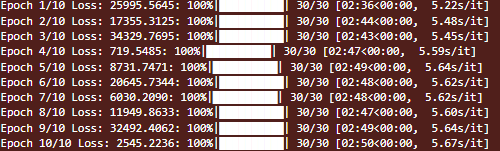